# Advantage Actor Critic

## Imports

In [1]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
    
# Reward Manager for including custom rewards
from minihack import RewardManager

Set device to use GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Helper Functions

Converts state into form that the neural network can read

In [3]:
def format_state(state):

    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
     
    return {"glyphs":glyphs, "message":message}

In [4]:
def compute_returns(rewards, gamma):
    """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardize Returns 
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [5]:
def plot_results(env_name,scores, color,ylim):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Average Reward")
    
    plt.title(f"A2C - {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.yticks(np.arange(ylim[0], ylim[1], 1.00))
    plt.legend(loc=4)
    plt.savefig(f"A2C - {env_name}.png")
    plt.show()

## A2C Model 

In [6]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic, self).__init__()
        
        # Initialize first set of convolutional and pooling layers with a ReLU activation function 
        self.conv_layer1 = Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5)).to(device)
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize second set of of convolutional and pooling layers with a ReLU activation function 
        self.conv_layer2= Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)).to(device)
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize fully connected layers for glyph output after convolutional and pooling layers
        self.fully_conn_layer1 = Linear(in_features=1600, out_features=500).to(device)
        self.relu3 = ReLU()
        
        self.fully_conn_layer2 = Linear(in_features=500, out_features=128).to(device)
        self.relu4 = ReLU()
        
        # Initialize fully connected for message input 
        self.fully_conn_layer3 = Linear(in_features=256, out_features=128).to(device)
        self.relu5 = ReLU()
        
        # Initialize fully connected for combination of glyphs and message 
        self.fully_conn_layer4 = Linear(in_features=256, out_features=128).to(device)
        self.relu6 = ReLU()

        # To estimate the value function of the state 
        self.value_layer = nn.Linear(128, 1).to(device)

        # To calculate the probability of taking each action in the given state
        self.action_layer = nn.Linear(128, a_size).to(device)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers 
        glyphs_t = self.conv_layer1(glyphs_t)
        glyphs_t = self.relu1(glyphs_t)
        glyphs_t = self.maxpool1(glyphs_t)
        glyphs_t = self.conv_layer2(glyphs_t)
        glyphs_t = self.relu2(glyphs_t)
        glyphs_t = self.maxpool2(glyphs_t)
        
        # Platten the output from the final pooling layer and pass it through the fully connected layers 
        glyphs_t = glyphs_t.reshape(glyphs_t.shape[0], -1)
        glyphs_t = self.fully_conn_layer1(glyphs_t)
        glyphs_t = self.relu3(glyphs_t)
        glyphs_t = self.fully_conn_layer2(glyphs_t)
        glyphs_t = self.relu4(glyphs_t)
        
        # Pass the message input through a fully connected layer
        message_t = self.fully_conn_layer3(message_t)
        message_t = self.relu5(message_t)
        
        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        # Cat and Concat are used for different versions of PyTorch
        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)

        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.fully_conn_layer4(combined)
        combined = self.relu6(combined)
        
        # Pass the output from the previous fully connected layer through two seperate 
        # fully connected layers, one with a single output neuron (to estimate the state value function)
        # and the other with the number of output neurons equal to the number of actions 
        # (to estimate the action probabilities)
        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

# A2C Algorithm 

In [7]:
def actor_critic(env, model, seed, learning_rate, number_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train Actor Critic model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode

    Returns:
    policy: The neural network model after training that approximates the state value functions and action probabilities
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            
            # Get the probability distribution over actions and 
            # estimated state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            # Sample from the probability distribution to determine which action to take 
            action = distribution.sample()
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            # Store the reward, log of the probability of the action selected 
            # And
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            try:
                reward = reward.resize(1,1)
            except:pass
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, scores

In [8]:
def run_actor_critic(env,number_episodes,max_episode_length,iterations):
    """Trains Actor Critic model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env,
                                    model= ac_model, 
                                    seed=seed, 
                                    learning_rate=0.02,
                                    number_episodes=number_episodes, 
                                    max_episode_length=max_episode_length, 
                                    gamma=0.99 ,
                                    verbose=True)
        
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## Room 5x5 

In [9]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# The max number of epsidoe steps for the environment needs to be increased as it defaults to 250 for Navigation tasks
MOVE_ACTIONS = tuple(nethack.CompassDirection)
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)

room_5x5_scores = run_actor_critic(env,number_episodes=100,max_episode_length=200,iterations=5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  logger.warn(
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/home/sweets/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for 

Episode: 0 Reward: 0.99 Average Reward: 0.99 Steps 11
Episode: 1 Reward: -0.9999999999999999 Average Reward: -0.004999999999999949 Steps 100
Episode: 2 Reward: 0.45999999999999996 Average Reward: 0.15000000000000002 Steps 77
Episode: 3 Reward: 0.89 Average Reward: 0.335 Steps 46
Episode: 4 Reward: -0.30000000000000004 Average Reward: 0.20800000000000002 Steps 100
Episode: 5 Reward: 0.6699999999999999 Average Reward: 0.285 Steps 76
Episode: 6 Reward: 0.87 Average Reward: 0.3685714285714286 Steps 61
Episode: 7 Reward: 0.8300000000000001 Average Reward: 0.4262500000000001 Steps 67
Episode: 8 Reward: -0.30000000000000004 Average Reward: 0.3455555555555556 Steps 100
Episode: 9 Reward: 0.98 Average Reward: 0.409 Steps 7
Episode: 10 Reward: -0.29000000000000004 Average Reward: 0.34545454545454546 Steps 100
Episode: 11 Reward: 0.84 Average Reward: 0.38666666666666666 Steps 71
Episode: 12 Reward: 0.88 Average Reward: 0.42461538461538456 Steps 45
Episode: 13 Reward: 0.8 Average Reward: 0.4514285

Episode: 23 Reward: 0.8300000000000001 Average Reward: 0.5245833333333333 Steps 34
Episode: 24 Reward: 0.94 Average Reward: 0.5412 Steps 25
Episode: 25 Reward: 0.95 Average Reward: 0.5569230769230769 Steps 19
Episode: 26 Reward: 0.91 Average Reward: 0.57 Steps 17
Episode: 27 Reward: 0.89 Average Reward: 0.5814285714285713 Steps 25
Episode: 28 Reward: 0.78 Average Reward: 0.5882758620689654 Steps 30
Episode: 29 Reward: 0.97 Average Reward: 0.6009999999999999 Steps 15
Episode: 30 Reward: 0.98 Average Reward: 0.6132258064516128 Steps 10
Episode: 31 Reward: 0.99 Average Reward: 0.625 Steps 9
Episode: 32 Reward: 0.96 Average Reward: 0.6351515151515151 Steps 12
Episode: 33 Reward: 0.96 Average Reward: 0.6447058823529412 Steps 14
Episode: 34 Reward: 0.88 Average Reward: 0.6514285714285715 Steps 22
Episode: 35 Reward: 0.94 Average Reward: 0.6594444444444445 Steps 14
Episode: 36 Reward: 0.94 Average Reward: 0.6670270270270271 Steps 14
Episode: 37 Reward: 0.99 Average Reward: 0.6755263157894738 

Episode: 48 Reward: 1.0 Average Reward: 0.7612244897959185 Steps 8
Episode: 49 Reward: 0.9299999999999999 Average Reward: 0.7646000000000001 Steps 13
Episode: 50 Reward: 0.94 Average Reward: 0.7883999999999999 Steps 13
Episode: 51 Reward: 0.97 Average Reward: 0.7878000000000001 Steps 9
Episode: 52 Reward: 0.94 Average Reward: 0.7866 Steps 13
Episode: 53 Reward: 0.94 Average Reward: 0.7869999999999999 Steps 13
Episode: 54 Reward: 0.84 Average Reward: 0.8230000000000001 Steps 25
Episode: 55 Reward: 1.0 Average Reward: 0.8622 Steps 5
Episode: 56 Reward: 1.0 Average Reward: 0.9 Steps 5
Episode: 57 Reward: 1.0 Average Reward: 0.9028 Steps 5
Episode: 58 Reward: 0.96 Average Reward: 0.9060000000000001 Steps 12
Episode: 59 Reward: 0.98 Average Reward: 0.9078 Steps 9
Episode: 60 Reward: 1.0 Average Reward: 0.911 Steps 4
Episode: 61 Reward: 0.97 Average Reward: 0.912 Steps 13
Episode: 62 Reward: 0.92 Average Reward: 0.912 Steps 13
Episode: 63 Reward: 0.97 Average Reward: 0.9381999999999999 Steps

Episode: 76 Reward: 0.97 Average Reward: 0.9536 Steps 13
Episode: 77 Reward: 1.0 Average Reward: 0.955 Steps 16
Episode: 78 Reward: 0.9299999999999999 Average Reward: 0.955 Steps 20
Episode: 79 Reward: 0.99 Average Reward: 0.9558000000000001 Steps 9
Episode: 80 Reward: 0.99 Average Reward: 0.9576000000000002 Steps 11
Episode: 81 Reward: 0.92 Average Reward: 0.9560000000000001 Steps 23
Episode: 82 Reward: 0.96 Average Reward: 0.9552 Steps 17
Episode: 83 Reward: 0.96 Average Reward: 0.9544 Steps 15
Episode: 84 Reward: 0.99 Average Reward: 0.9544 Steps 9
Episode: 85 Reward: 0.98 Average Reward: 0.9547999999999999 Steps 14
Episode: 86 Reward: 0.99 Average Reward: 0.9564 Steps 10
Episode: 87 Reward: 0.95 Average Reward: 0.9562000000000002 Steps 13
Episode: 88 Reward: 0.95 Average Reward: 0.9580000000000001 Steps 15
Episode: 89 Reward: 0.97 Average Reward: 0.9582 Steps 11
Episode: 90 Reward: 0.96 Average Reward: 0.9573999999999999 Steps 12
Episode: 91 Reward: 0.98 Average Reward: 0.9578 Step

Plot results

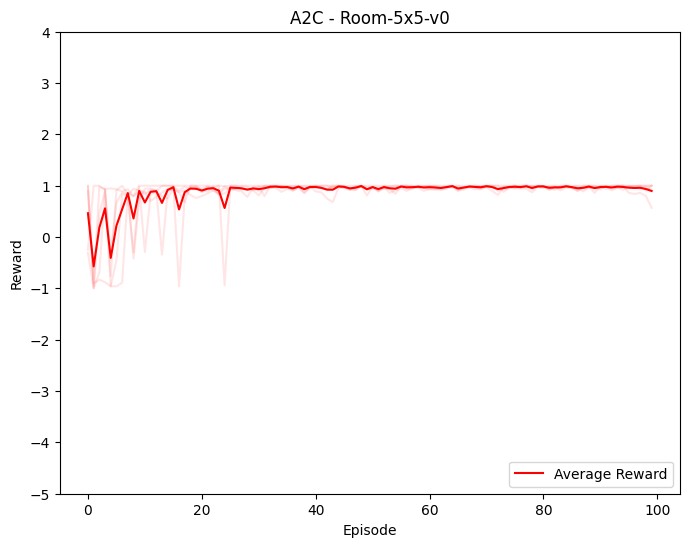

In [10]:
plot_results(env_name="Room-5x5-v0",scores=room_5x5_scores, ylim =(-5,5), color = "red" )

# Eat 

In [11]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
MOVE_ACTIONS += (nethack.Command.EAT,)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)

# For skills acquisition tasks more training is required so not only are the episodes longer 
# but the number of episodes is also increased from 100 to 1000 
eat_scores = run_actor_critic(env,number_episodes=150,max_episode_length=200,iterations=5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


Episode: 0 Reward: -0.6300000000000001 Average Reward: -0.6300000000000001 Steps 199


/tmp/ipykernel_7289/3114879281.py:81: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -1.9899999999999998 Average Reward: -1.31 Steps 199
Episode: 2 Reward: -1.64 Average Reward: -1.42 Steps 199
Episode: 3 Reward: -0.8 Average Reward: -1.265 Steps 199
Episode: 4 Reward: -0.73 Average Reward: -1.158 Steps 199
Episode: 5 Reward: -0.66 Average Reward: -1.075 Steps 199
Episode: 6 Reward: -0.6799999999999999 Average Reward: -1.0185714285714285 Steps 199
Episode: 7 Reward: -0.68 Average Reward: -0.9762500000000001 Steps 199
Episode: 8 Reward: -0.8700000000000001 Average Reward: -0.9644444444444444 Steps 199
Episode: 9 Reward: -1.03 Average Reward: -0.9709999999999999 Steps 199
Episode: 10 Reward: 0.58 Average Reward: -0.83 Steps 73
Episode: 11 Reward: -0.8500000000000001 Average Reward: -0.8316666666666666 Steps 199
Episode: 12 Reward: -0.93 Average Reward: -0.8392307692307691 Steps 199
Episode: 13 Reward: -0.9 Average Reward: -0.8435714285714285 Steps 199
Episode: 14 Reward: -1.03 Average Reward: -0.8559999999999999 Steps 199
Episode: 15 Reward: -1.07 Aver

Episode: 108 Reward: -1.9499999999999997 Average Reward: -0.7506000000000002 Steps 199
Episode: 109 Reward: -1.9799999999999998 Average Reward: -0.7781999999999999 Steps 199
Episode: 110 Reward: -1.9599999999999997 Average Reward: -0.8062 Steps 199
Episode: 111 Reward: -1.9799999999999998 Average Reward: -0.8319999999999999 Steps 199
Episode: 112 Reward: -1.9699999999999998 Average Reward: -0.8605999999999999 Steps 199
Episode: 113 Reward: -1.9799999999999998 Average Reward: -0.9115999999999999 Steps 199
Episode: 114 Reward: -1.9599999999999997 Average Reward: -0.9381999999999999 Steps 199
Episode: 115 Reward: -1.9899999999999998 Average Reward: -0.9636 Steps 199
Episode: 116 Reward: -1.9799999999999998 Average Reward: -0.9879999999999999 Steps 199
Episode: 117 Reward: -1.9599999999999997 Average Reward: -1.0368 Steps 199
Episode: 118 Reward: -1.9499999999999997 Average Reward: -1.0598 Steps 199
Episode: 119 Reward: -1.9699999999999998 Average Reward: -1.109 Steps 199
Episode: 120 Rewa

Episode: 62 Reward: 0.49 Average Reward: -0.09980000000000004 Steps 150
Episode: 63 Reward: -0.8400000000000001 Average Reward: -0.12240000000000005 Steps 199
Episode: 64 Reward: 0.2599999999999999 Average Reward: -0.12200000000000003 Steps 155
Episode: 65 Reward: -0.75 Average Reward: -0.12420000000000005 Steps 199
Episode: 66 Reward: 0.94 Average Reward: -0.09300000000000004 Steps 17
Episode: 67 Reward: -0.78 Average Reward: -0.11920000000000007 Steps 199
Episode: 68 Reward: 0.84 Average Reward: -0.08820000000000004 Steps 41
Episode: 69 Reward: -0.78 Average Reward: -0.09240000000000004 Steps 199
Episode: 70 Reward: 0.19999999999999996 Average Reward: -0.09740000000000006 Steps 197
Episode: 71 Reward: 0.73 Average Reward: -0.07140000000000005 Steps 70
Episode: 72 Reward: 0.92 Average Reward: -0.06340000000000007 Steps 28
Episode: 73 Reward: -0.8300000000000001 Average Reward: -0.08960000000000004 Steps 199
Episode: 74 Reward: 0.94 Average Reward: -0.07980000000000007 Steps 25
Episode

Episode: 25 Reward: 0.86 Average Reward: -0.5184615384615385 Steps 34
Episode: 26 Reward: -0.8800000000000001 Average Reward: -0.5318518518518519 Steps 199
Episode: 27 Reward: -0.8800000000000001 Average Reward: -0.5442857142857144 Steps 199
Episode: 28 Reward: -0.77 Average Reward: -0.5520689655172416 Steps 199
Episode: 29 Reward: -0.8200000000000001 Average Reward: -0.5610000000000002 Steps 199
Episode: 30 Reward: 0.79 Average Reward: -0.5174193548387099 Steps 45
Episode: 31 Reward: -0.7200000000000001 Average Reward: -0.52375 Steps 199
Episode: 32 Reward: -0.8 Average Reward: -0.5321212121212122 Steps 199
Episode: 33 Reward: 0.08999999999999997 Average Reward: -0.5138235294117648 Steps 194
Episode: 34 Reward: -0.7200000000000001 Average Reward: -0.5197142857142858 Steps 199
Episode: 35 Reward: -0.63 Average Reward: -0.5227777777777778 Steps 199
Episode: 36 Reward: -0.66 Average Reward: -0.5264864864864865 Steps 199
Episode: 37 Reward: -0.77 Average Reward: -0.5328947368421053 Steps 

Episode: 135 Reward: -0.8200000000000001 Average Reward: -0.4916000000000001 Steps 199
Episode: 136 Reward: 0.5700000000000001 Average Reward: -0.4660000000000001 Steps 121
Episode: 137 Reward: -0.8700000000000001 Average Reward: -0.46860000000000007 Steps 199
Episode: 138 Reward: -0.8700000000000001 Average Reward: -0.4698000000000001 Steps 199
Episode: 139 Reward: 0.46 Average Reward: -0.4456000000000001 Steps 172
Episode: 140 Reward: 0.97 Average Reward: -0.4100000000000001 Steps 9
Episode: 141 Reward: -0.7700000000000001 Average Reward: -0.4402000000000001 Steps 199
Episode: 142 Reward: 0.93 Average Reward: -0.4112000000000001 Steps 26
Episode: 143 Reward: 0.83 Average Reward: -0.38100000000000006 Steps 52
Episode: 144 Reward: -0.8700000000000001 Average Reward: -0.3848000000000001 Steps 199
Episode: 145 Reward: -0.8400000000000001 Average Reward: -0.4130000000000001 Steps 199
Episode: 146 Reward: -0.9200000000000002 Average Reward: -0.4206000000000001 Steps 199
Episode: 147 Reward

Episode: 92 Reward: -0.6799999999999999 Average Reward: -0.494 Steps 199
Episode: 93 Reward: 0.78 Average Reward: -0.4658 Steps 59
Episode: 94 Reward: -0.6400000000000001 Average Reward: -0.46340000000000003 Steps 199
Episode: 95 Reward: -0.55 Average Reward: -0.46020000000000005 Steps 199
Episode: 96 Reward: -0.7000000000000002 Average Reward: -0.483 Steps 199
Episode: 97 Reward: -0.8900000000000001 Average Reward: -0.5102 Steps 199
Episode: 98 Reward: -0.54 Average Reward: -0.5034000000000001 Steps 199
Episode: 99 Reward: -0.77 Average Reward: -0.504 Steps 199
Episode: 100 Reward: -0.5700000000000001 Average Reward: -0.5006 Steps 199
Episode: 101 Reward: -0.56 Average Reward: -0.49560000000000004 Steps 199
Episode: 102 Reward: -0.7 Average Reward: -0.49339999999999995 Steps 199
Episode: 103 Reward: 0.21999999999999997 Average Reward: -0.4754 Steps 181
Episode: 104 Reward: -0.56 Average Reward: -0.5008 Steps 199
Episode: 105 Reward: -0.74 Average Reward: -0.498 Steps 199
Episode: 106 

Episode: 52 Reward: -0.8600000000000001 Average Reward: -0.4978000000000001 Steps 199
Episode: 53 Reward: 0.4499999999999999 Average Reward: -0.475 Steps 168
Episode: 54 Reward: 0.20999999999999974 Average Reward: -0.4546 Steps 176
Episode: 55 Reward: 0.6 Average Reward: -0.4036 Steps 109
Episode: 56 Reward: -0.8300000000000001 Average Reward: -0.40120000000000006 Steps 199
Episode: 57 Reward: -0.7 Average Reward: -0.40080000000000005 Steps 199
Episode: 58 Reward: -0.71 Average Reward: -0.3990000000000001 Steps 199
Episode: 59 Reward: -0.64 Average Reward: -0.39940000000000014 Steps 199
Episode: 60 Reward: -0.65 Average Reward: -0.397 Steps 199
Episode: 61 Reward: 0.59 Average Reward: -0.37300000000000005 Steps 105
Episode: 62 Reward: -0.6400000000000001 Average Reward: -0.3708000000000001 Steps 199
Episode: 63 Reward: 0.92 Average Reward: -0.33740000000000003 Steps 23
Episode: 64 Reward: 0.77 Average Reward: -0.30920000000000003 Steps 55
Episode: 65 Reward: -0.8300000000000001 Average

Plot results

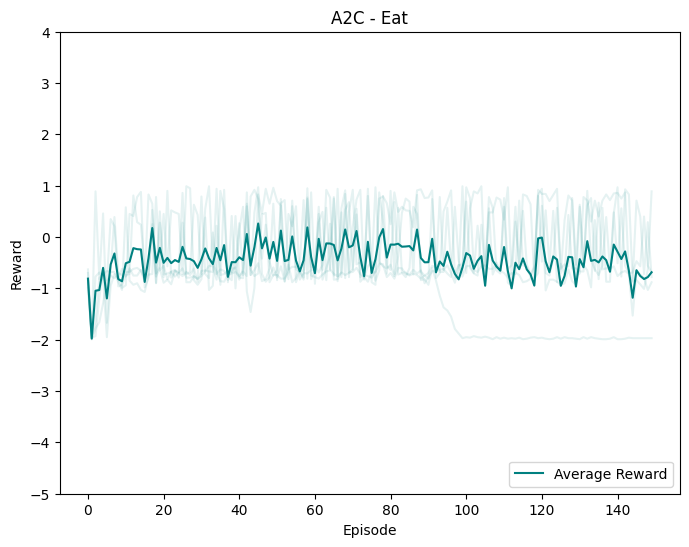

In [12]:
plot_results(env_name="Eat",scores=eat_scores,  ylim =(-5,5),color = "teal")

# Quest Hard 

In [13]:
# Custom Reward for exploring more of the map 
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [14]:
# Restricting the action space
QUEST_ACTIONS = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF
)

reward_gen = RewardManager()

# Random reward included to prevent reward glitch 
reward_gen.add_eat_event("apple", reward=1)

# Custom Rewards for long corridors at top and bottom 
reward_gen.add_coordinate_event((3,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze
reward_gen.add_custom_reward_fn(maze_explore_reward)

In [15]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS)

quest_hard_exp_scores = run_actor_critic(env, number_episodes = 200, max_episode_length = 250,iterations = 5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (9, 9)
  logger.warn(
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (55, 80)
  logger.warn(


Episode: 0 Reward: -1.83 Average Reward: -1.83 Steps 249


/tmp/ipykernel_7289/3114879281.py:81: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -2.49 Average Reward: -2.16 Steps 249
Episode: 2 Reward: -1.58 Average Reward: -1.9666666666666668 Steps 249
Episode: 3 Reward: -1.67 Average Reward: -1.8925 Steps 249
Episode: 4 Reward: -1.5699999999999998 Average Reward: -1.828 Steps 249
Episode: 5 Reward: -1.48 Average Reward: -1.7700000000000002 Steps 249
Episode: 6 Reward: -1.55 Average Reward: -1.7385714285714289 Steps 249
Episode: 7 Reward: -1.51 Average Reward: -1.71 Steps 249
Episode: 8 Reward: -1.15 Average Reward: -1.6477777777777778 Steps 249
Episode: 9 Reward: -1.47 Average Reward: -1.6300000000000001 Steps 249
Episode: 10 Reward: -1.16 Average Reward: -1.5872727272727274 Steps 249
Episode: 11 Reward: -0.79 Average Reward: -1.5208333333333333 Steps 249
Episode: 12 Reward: -0.8599999999999999 Average Reward: -1.47 Steps 249
Episode: 13 Reward: -0.51 Average Reward: -1.4014285714285715 Steps 249
Episode: 14 Reward: -0.6499999999999999 Average Reward: -1.3513333333333333 Steps 249
Episode: 15 Reward: -1.26 

Episode: 120 Reward: -2.37 Average Reward: -2.364 Steps 249
Episode: 121 Reward: -2.49 Average Reward: -2.364 Steps 249
Episode: 122 Reward: -2.49 Average Reward: -2.3729999999999998 Steps 249
Episode: 123 Reward: -2.48 Average Reward: -2.3752 Steps 249
Episode: 124 Reward: -2.38 Average Reward: -2.373 Steps 249
Episode: 125 Reward: -2.49 Average Reward: -2.3729999999999998 Steps 249
Episode: 126 Reward: -2.49 Average Reward: -2.3729999999999998 Steps 249
Episode: 127 Reward: -2.48 Average Reward: -2.3822 Steps 249
Episode: 128 Reward: -1.71 Average Reward: -2.3666 Steps 249
Episode: 129 Reward: -2.15 Average Reward: -2.3598 Steps 249
Episode: 130 Reward: -2.49 Average Reward: -2.3622 Steps 249
Episode: 131 Reward: -2.49 Average Reward: -2.3712 Steps 249
Episode: 132 Reward: -2.49 Average Reward: -2.3712 Steps 249
Episode: 133 Reward: -2.49 Average Reward: -2.3779999999999997 Steps 249
Episode: 134 Reward: -2.48 Average Reward: -2.3778 Steps 249
Episode: 135 Reward: -2.04 Average Rewar

Episode: 42 Reward: -2.49 Average Reward: -2.3151162790697675 Steps 249
Episode: 43 Reward: -2.49 Average Reward: -2.319090909090909 Steps 249
Episode: 44 Reward: -2.49 Average Reward: -2.3228888888888886 Steps 249
Episode: 45 Reward: -2.49 Average Reward: -2.3265217391304343 Steps 249
Episode: 46 Reward: -2.49 Average Reward: -2.3299999999999996 Steps 249
Episode: 47 Reward: -2.49 Average Reward: -2.3333333333333335 Steps 249
Episode: 48 Reward: -2.49 Average Reward: -2.3365306122448977 Steps 249
Episode: 49 Reward: -2.49 Average Reward: -2.3396 Steps 249
Episode: 50 Reward: -2.49 Average Reward: -2.3596 Steps 249
Episode: 51 Reward: -2.49 Average Reward: -2.3596 Steps 249
Episode: 52 Reward: -2.49 Average Reward: -2.389 Steps 249
Episode: 53 Reward: -2.49 Average Reward: -2.416 Steps 249
Episode: 54 Reward: -2.49 Average Reward: -2.4341999999999997 Steps 249
Episode: 55 Reward: -2.49 Average Reward: -2.4551999999999996 Steps 249
Episode: 56 Reward: -2.49 Average Reward: -2.4619999999

Episode: 179 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 180 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 181 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 182 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 183 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 184 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 185 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 186 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 187 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 188 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 189 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 190 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 191 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 192 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 193 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 194 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 195 Reward: -2.49 Average Reward: -2.49 Steps 2

Episode: 94 Reward: -1.12 Average Reward: -1.0546 Steps 249
Episode: 95 Reward: -0.19999999999999996 Average Reward: -1.0522 Steps 249
Episode: 96 Reward: -1.27 Average Reward: -1.0776000000000001 Steps 249
Episode: 97 Reward: -0.2600000000000001 Average Reward: -1.0704 Steps 249
Episode: 98 Reward: -1.43 Average Reward: -1.0878 Steps 249
Episode: 99 Reward: -0.22999999999999987 Average Reward: -1.0864 Steps 249
Episode: 100 Reward: -0.9500000000000001 Average Reward: -1.0937999999999999 Steps 249
Episode: 101 Reward: -0.69 Average Reward: -1.1062 Steps 249
Episode: 102 Reward: -1.5300000000000002 Average Reward: -1.1416 Steps 249
Episode: 103 Reward: 0.3200000000000001 Average Reward: -1.119 Steps 249
Episode: 104 Reward: -0.3500000000000001 Average Reward: -1.1186 Steps 249
Episode: 105 Reward: -1.08 Average Reward: -1.1084 Steps 249
Episode: 106 Reward: -0.6900000000000001 Average Reward: -1.0763999999999998 Steps 249
Episode: 107 Reward: -1.77 Average Reward: -1.0846 Steps 249
Epis

Episode: 16 Reward: -2.1100000000000003 Average Reward: -1.6011764705882352 Steps 249
Episode: 17 Reward: -1.3900000000000001 Average Reward: -1.5894444444444444 Steps 249
Episode: 18 Reward: -1.65 Average Reward: -1.5926315789473684 Steps 249
Episode: 19 Reward: -2.04 Average Reward: -1.6149999999999998 Steps 249
Episode: 20 Reward: -2.34 Average Reward: -1.6495238095238096 Steps 249
Episode: 21 Reward: -0.8600000000000001 Average Reward: -1.6136363636363635 Steps 249
Episode: 22 Reward: -1.81 Average Reward: -1.6221739130434785 Steps 249
Episode: 23 Reward: -0.99 Average Reward: -1.5958333333333332 Steps 249
Episode: 24 Reward: -0.98 Average Reward: -1.5711999999999997 Steps 249
Episode: 25 Reward: -1.6099999999999999 Average Reward: -1.5726923076923074 Steps 249
Episode: 26 Reward: -1.89 Average Reward: -1.5844444444444443 Steps 249
Episode: 27 Reward: -1.61 Average Reward: -1.5853571428571427 Steps 249
Episode: 28 Reward: -1.26 Average Reward: -1.5741379310344825 Steps 249
Episode:

Episode: 133 Reward: -2.49 Average Reward: -2.3256 Steps 249
Episode: 134 Reward: -2.26 Average Reward: -2.3254 Steps 249
Episode: 135 Reward: -2.49 Average Reward: -2.3256 Steps 249
Episode: 136 Reward: -2.49 Average Reward: -2.3324000000000003 Steps 249
Episode: 137 Reward: -2.49 Average Reward: -2.3326 Steps 249
Episode: 138 Reward: -2.49 Average Reward: -2.3326 Steps 249
Episode: 139 Reward: -2.48 Average Reward: -2.3348 Steps 249
Episode: 140 Reward: -2.48 Average Reward: -2.3370000000000006 Steps 249
Episode: 141 Reward: -2.37 Average Reward: -2.3370000000000006 Steps 249
Episode: 142 Reward: -2.37 Average Reward: -2.3346000000000005 Steps 249
Episode: 143 Reward: -2.49 Average Reward: -2.3612 Steps 249
Episode: 144 Reward: -2.49 Average Reward: -2.3612 Steps 249
Episode: 145 Reward: -2.26 Average Reward: -2.3566000000000003 Steps 249
Episode: 146 Reward: -1.93 Average Reward: -2.3588000000000005 Steps 249
Episode: 147 Reward: -2.49 Average Reward: -2.3612 Steps 249
Episode: 148 

Episode: 54 Reward: -2.49 Average Reward: -2.4244 Steps 249
Episode: 55 Reward: -2.49 Average Reward: -2.4312 Steps 249
Episode: 56 Reward: -2.49 Average Reward: -2.4368 Steps 249
Episode: 57 Reward: -2.49 Average Reward: -2.4501999999999997 Steps 249
Episode: 58 Reward: -2.49 Average Reward: -2.4604 Steps 249
Episode: 59 Reward: -2.49 Average Reward: -2.4730000000000003 Steps 249
Episode: 60 Reward: -2.49 Average Reward: -2.483 Steps 249
Episode: 61 Reward: -2.49 Average Reward: -2.4876 Steps 249
Episode: 62 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 63 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 64 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 65 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 66 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 67 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 68 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 69 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 70 Reward: -2.49 Average

Episode: 193 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 194 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 195 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 196 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 197 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 198 Reward: -2.49 Average Reward: -2.49 Steps 249
Episode: 199 Reward: -2.49 Average Reward: -2.49 Steps 249


Plot results

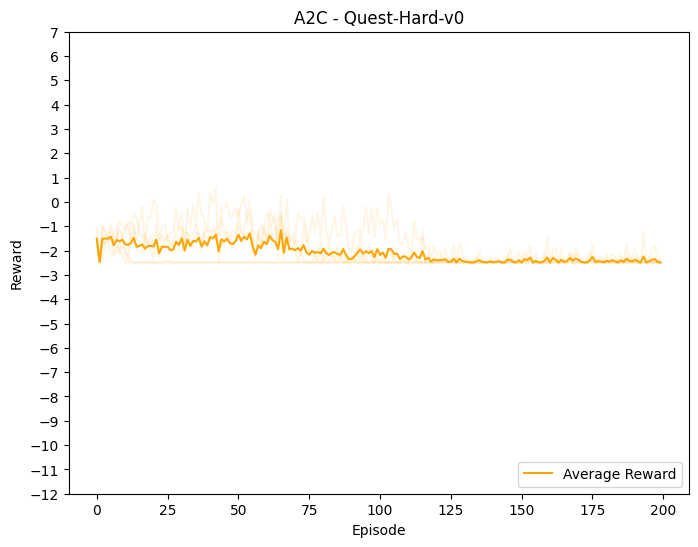

In [16]:
plot_results(env_name="Quest-Hard-v0",scores=quest_hard_exp_scores,ylim=(-12,8), color = "orange" )